In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [4]:
import sqlite3
path_general = "C:/py-restaurant-data-analysis1/"
con = sqlite3.connect(path_general + "db.sqlite3")

In [5]:
df_restaurant = pd.read_sql("SELECT restaurant_orderitem.id, quantity, datetime, price, name FROM restaurant_orderitem JOIN restaurant_order on restaurant_orderitem.order_id = restaurant_order.id JOIN restaurant_product rp on restaurant_orderitem.product_id = rp.id", con)

In [6]:
from pathlib import Path
filepath = Path(path_general + "order.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
df_restaurant.to_csv(filepath)

In [7]:
df_restaurant

,id,quantity,datetime,price,name
0,1,2,2019-08-03 20:25:00,0.80,Plain Papadum
1,2,1,2019-08-03 20:25:00,12.95,King Prawn Balti
2,3,1,2019-08-03 20:25:00,2.95,Garlic Naan
3,4,1,2019-08-03 20:25:00,3.95,Mushroom Rice
4,5,1,2019-08-03 20:25:00,8.95,Paneer Tikka Masala
...,...,...,...,...,...
74813,74814,2,2016-05-18 18:53:00,17.95,House Red wine 75cl
74814,74815,2,2016-05-14 19:28:00,17.95,House Red wine 75cl
74815,74816,2,2016-05-10 13:18:00,17.95,House Red wine 75cl
74816,74817,1,2016-04-07 19:04:00,17.95,House white wine 75cl


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [8]:
top_10_products_sort_by_quantity = df_restaurant.sort_values(by="quantity", ascending=False).head(10)
top_10_products_sort_by_quantity

,id,quantity,datetime,price,name
73365,73366,51,2019-07-18 18:38:00,12.95,King Prawn Shaslick
7864,7865,32,2018-06-05 12:10:00,0.80,Plain Papadum
14105,14106,30,2017-09-18 16:33:00,2.60,Plain Naan
7158,7159,28,2018-11-27 11:48:00,0.80,Plain Papadum
61685,61686,25,2017-09-18 16:54:00,8.95,Chicken Tikka Masala
61683,61684,25,2017-09-18 16:54:00,8.95,Korma
47979,47980,20,2017-09-18 16:33:00,5.95,Royal Paneer
61684,61685,20,2017-09-18 16:54:00,8.95,Paneer Tikka Masala
24953,24954,20,2017-09-18 16:54:00,2.95,Plain Rice
24954,24955,20,2017-09-18 16:33:00,2.95,Raitha


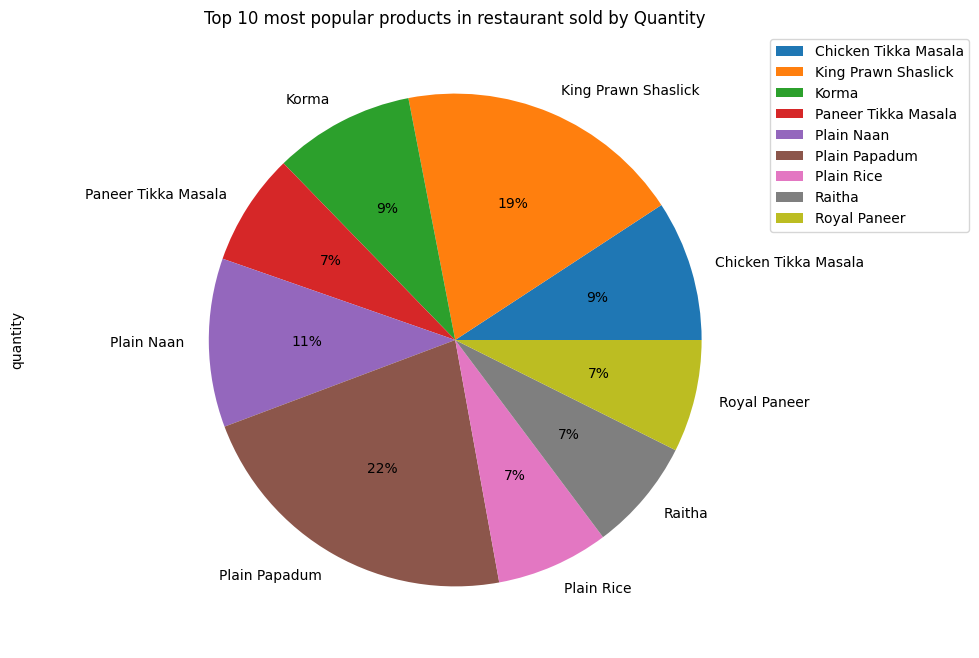

In [21]:
plot = top_10_products_sort_by_quantity.groupby(["name"]). sum ().plot(kind="pie", y="quantity", autopct="%1.0f%%", title="Top 10 most popular products in restaurant sold by Quantity")
plot.legend(bbox_to_anchor=(1, 1))
plot.yaxis.set_label_coords(-0.2, 0.5)
plot.figure.set_size_inches(10, 8)

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [10]:
df_restaurant.insert(loc= len(df_restaurant.columns) , column="item price", value=df_restaurant.quantity * df_restaurant.price)


In [26]:
top_10_products_sort_by_item_price = df_restaurant.sort_values(by="item price", ascending=False).head(10)
top_10_products_sort_by_item_price

,id,quantity,datetime,price,name,item price,hour,day of the week
73365,73366,51,2019-07-18 18:38:00,12.95,King Prawn Shaslick,660.45,18,3
61685,61686,25,2017-09-18 16:54:00,8.95,Chicken Tikka Masala,223.75,16,0
61683,61684,25,2017-09-18 16:54:00,8.95,Korma,223.75,16,0
69500,69501,20,2017-09-18 16:54:00,9.95,Chicken Biryani,199.00,16,0
69501,69502,20,2017-09-18 16:54:00,9.95,Vegetable Biryani,199.00,16,0
61684,61685,20,2017-09-18 16:54:00,8.95,Paneer Tikka Masala,179.00,16,0
47979,47980,20,2017-09-18 16:33:00,5.95,Royal Paneer,119.00,16,0
47978,47979,20,2017-09-18 16:54:00,5.95,Tarka Dall,119.00,16,0
35978,35979,20,2017-09-18 16:33:00,3.95,Meat Samosa,79.00,16,0
35979,35980,20,2017-09-18 16:33:00,3.95,Onion Bhajee,79.00,16,0


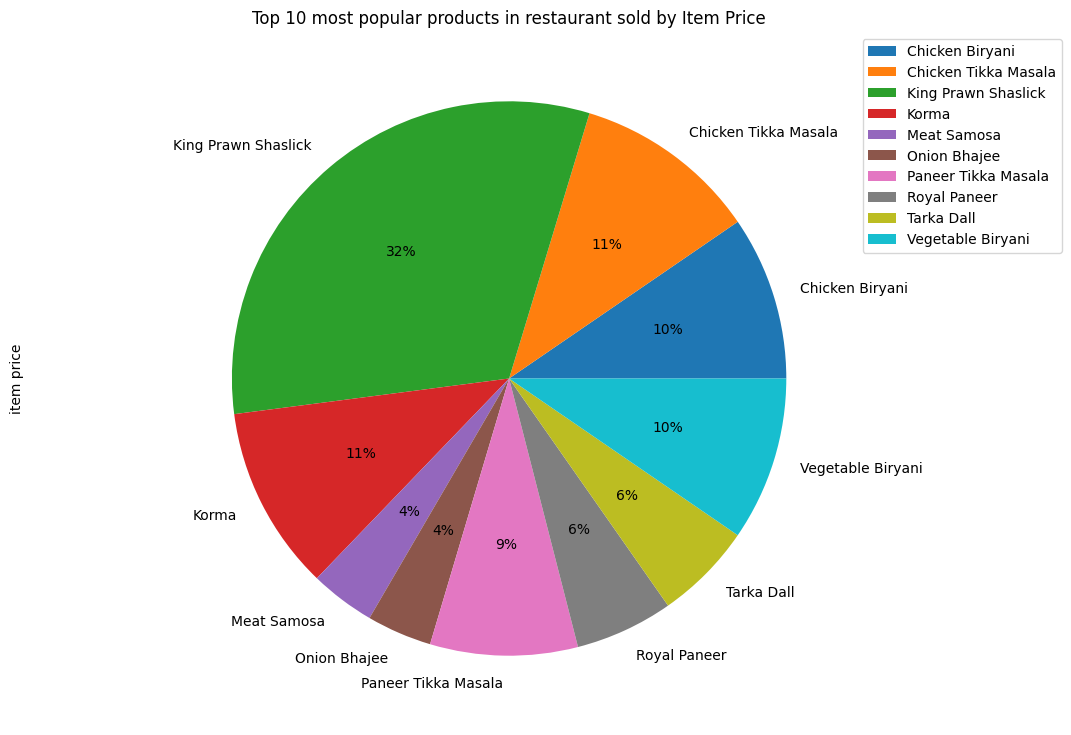

In [25]:
plot = top_10_products_sort_by_item_price.groupby(["name"]). sum ().plot(kind="pie", y="item price", autopct="%1.0f%%", title="Top 10 most popular products in restaurant sold by Item Price")
plot.legend(bbox_to_anchor=(1, 1))
plot.yaxis.set_label_coords(-0.2, 0.5)
plot.figure.set_size_inches(10, 9)

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [13]:
df_restaurant.insert(loc= len(df_restaurant.columns) , column="hour", value=pd.to_datetime(df_restaurant["datetime"]).dt.hour)


In [14]:
oder_hour = df_restaurant[["hour", "price"]].groupby("hour").sum()

<BarContainer object of 23 artists>

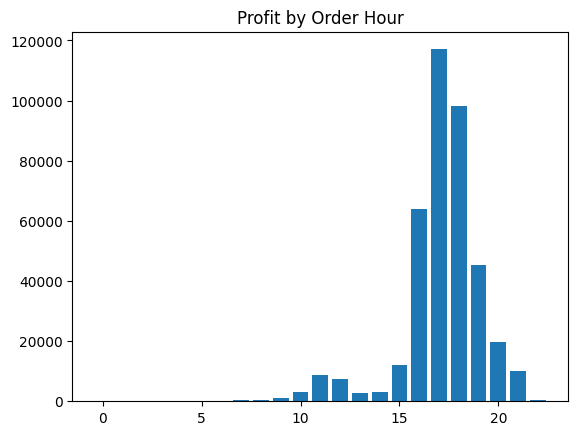

In [15]:
from matplotlib import pyplot as plt
hours = [i for i in range(23)]
plt.title("Profit by Order Hour")
plt.bar(hours, oder_hour.price)

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

In [16]:
df_restaurant.insert(loc= len(df_restaurant.columns) , column="day of the week", value=pd.to_datetime(df_restaurant["datetime"]).dt.day_of_week)

In [17]:
oder_day_of_the_week = df_restaurant[["day of the week", "price"]].groupby("day of the week").sum()

<BarContainer object of 7 artists>

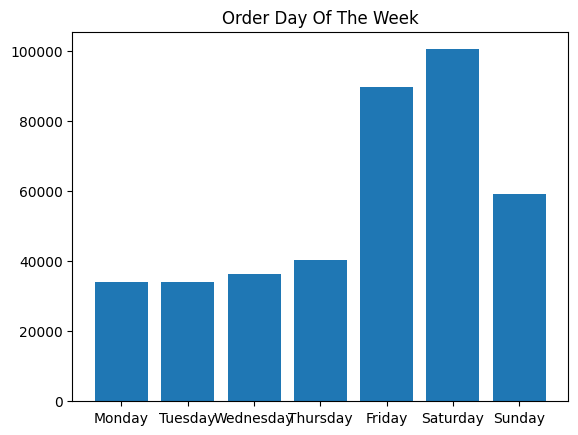

In [18]:
from matplotlib import pyplot as plt
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.title("Order Day Of The Week")
plt.bar(days, oder_day_of_the_week.price)

In [19]:
df_restaurant.corr(numeric_only=True)

,id,quantity,price,item price,hour,day of the week
id,1.000000,-0.240006,0.959903,0.640813,-0.028013,-0.009098
quantity,-0.240006,1.000000,-0.226757,0.320474,-0.036596,-0.007267
price,0.959903,-0.226757,1.000000,0.676986,-0.025130,-0.010750
item price,0.640813,0.320474,0.676986,1.000000,-0.048970,-0.018091
hour,-0.028013,-0.036596,-0.025130,-0.048970,1.000000,-0.039187
day of the week,-0.009098,-0.007267,-0.010750,-0.018091,-0.039187,1.000000
